# HW 2 - Разложение матриц градиентным методом

Цель задания: В ходе реализации [разложения Таккера](https://proceedings.neurips.cc/paper/2018/file/45a766fa266ea2ebeb6680fa139d2a3d-Paper.pdf) градиентным методом освоить pyTorch и реализовать подходы оптимизации параметров модели (в отсутствии готовых решений).

[Более-менее внятное описание алгоритма канонического разложения](https://www.alexejgossmann.com/tensor_decomposition_tucker/)

In [1]:
import random
import time
import torch
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from torch import nn
from tensorly import tenalg
import tensorly as tl
from sklearn.metrics import mean_squared_error as mse

from time import time

torch.manual_seed(0)

## 1 Создайте 3х мерный тензор
Размер тензора не меньше 100 по каждой из размерностей.

Заполните случайными целыми числами в диапазоне от 0 до 9.

Примечание: разложение будет корректно работать со случайным тензором, только если изначально создавать случайные ядро и матрицы, а потом по ним формировать тензор. Работайте с типом *torch.Tensor.double*.

In [2]:
def tensor_mul_mat(tensor, list_of_mat):
    """Возвращает произведение тензора на матрицы"""
    D = tensor.reshape(tensor.shape[0], -1)
    res = tl.matmul(tl.tensor(D.T), tl.tensor(list_of_mat[0].T)).reshape(tensor.shape[1], -1)
    res = tl.matmul(res.T, tl.tensor(list_of_mat[1].T)).reshape(tensor.shape[2], -1)
    res = tl.matmul(res.T, tl.tensor(list_of_mat[2].T)).reshape((list_of_mat[0].shape[0], 
                                                      list_of_mat[1].shape[0], 
                                                      list_of_mat[2].shape[0])) + np.random.normal(0.01, .1) # random noise
    return res

In [3]:
# Создадим тензор: размер тензора и r задаётся
def get_tensor(size=(100,200,150), r=(10, 20, 30)):
    # data - тензор с заданной размерностью
    # U - список матриц
    # G - ядро разложения
    G = np.random.randint(0, 10, size=r).astype(np.double)
    U = []
    res = 0
    for i, size_i in enumerate(size):
        u = np.random.randint(0, 10, size=(size_i, r[i])).astype(np.double)
        U.append(u)
        
        
    res = tensor_mul_mat(G, U)
    
    return res, U, G

res, U, G = get_tensor()

In [4]:
res

array([[[3008342.0620504, 2714155.0620504, 2835318.0620504, ...,
         3368012.0620504, 2711136.0620504, 3043893.0620504],
        [3362775.0620504, 3033291.0620504, 3143700.0620504, ...,
         3768277.0620504, 3019764.0620504, 3395812.0620504],
        [3121508.0620504, 2797988.0620504, 2933399.0620504, ...,
         3491283.0620504, 2797783.0620504, 3163504.0620504],
        ...,
        [3464730.0620504, 3122492.0620504, 3245578.0620504, ...,
         3868978.0620504, 3165361.0620504, 3519304.0620504],
        [3708534.0620504, 3330432.0620504, 3473189.0620504, ...,
         4149996.0620504, 3364825.0620504, 3750165.0620504],
        [3558482.0620504, 3216626.0620504, 3330411.0620504, ...,
         3982076.0620504, 3227528.0620504, 3608240.0620504]],

       [[2735232.0620504, 2460969.0620504, 2574459.0620504, ...,
         3062917.0620504, 2455404.0620504, 2762887.0620504],
        [3061156.0620504, 2755360.0620504, 2862685.0620504, ...,
         3431132.0620504, 2745204.0620

Сгенерируйте тензор и добавьте к нему случайный шум с размерностью *1e-2*

In [5]:
data, U, G = get_tensor(size=(10, 10, 10), r=(2, 2, 2))
data.shape, [u.shape for u in U], G.shape
data

array([[[ 1857.08560934,  1293.08560934,  2565.08560934,  1140.08560934,
           861.08560934,   288.08560934,  1569.08560934,  2571.08560934,
          2568.08560934,  1152.08560934],
        [ 3567.08560934,  2403.08560934,  4995.08560934,  2220.08560934,
          1611.08560934,   528.08560934,  3039.08560934,  4941.08560934,
          4968.08560934,  2112.08560934],
        [  558.08560934,   342.08560934,   810.08560934,   360.08560934,
           234.08560934,    72.08560934,   486.08560934,   774.08560934,
           792.08560934,   288.08560934],
        [ 1674.08560934,  1026.08560934,  2430.08560934,  1080.08560934,
           702.08560934,   216.08560934,  1458.08560934,  2322.08560934,
          2376.08560934,   864.08560934],
        [  594.08560934,   426.08560934,   810.08560934,   360.08560934,
           282.08560934,    96.08560934,   498.08560934,   822.08560934,
           816.08560934,   384.08560934],
        [ 1488.08560934,   912.08560934,  2160.08560934,   9

## 2 Реализуйте метод для восстановления тензора по разложению

In [6]:
# Функция, восстанавливающая тензор по ядру и матрицам
def repair_tensor(G_, U):
    data = tensor_mul_mat(G_, U)
    # data - восстановленный тензор из матриц и ядра
    # U - список матриц
    # G_ - ядро разложения

    return data

In [7]:
rep_tensor = repair_tensor(G, U)
rep_tensor

array([[[ 1857.09525895,  1293.09525895,  2565.09525895,  1140.09525895,
           861.09525895,   288.09525895,  1569.09525895,  2571.09525895,
          2568.09525895,  1152.09525895],
        [ 3567.09525895,  2403.09525895,  4995.09525895,  2220.09525895,
          1611.09525895,   528.09525895,  3039.09525895,  4941.09525895,
          4968.09525895,  2112.09525895],
        [  558.09525895,   342.09525895,   810.09525895,   360.09525895,
           234.09525895,    72.09525895,   486.09525895,   774.09525895,
           792.09525895,   288.09525895],
        [ 1674.09525895,  1026.09525895,  2430.09525895,  1080.09525895,
           702.09525895,   216.09525895,  1458.09525895,  2322.09525895,
          2376.09525895,   864.09525895],
        [  594.09525895,   426.09525895,   810.09525895,   360.09525895,
           282.09525895,    96.09525895,   498.09525895,   822.09525895,
           816.09525895,   384.09525895],
        [ 1488.09525895,   912.09525895,  2160.09525895,   9

## 3 Сделайте разложение библиотечным методом
Пакет можете брать любой

In [8]:
def get_tensor_box(size=(100,200,150), r=(10, 20, 30)):
    # data - тензор с заданной размерностью
    # U - список матриц
    # G - ядро разложения
    G = np.random.randint(0, 10, size=r).astype(np.double)
    U = []
    res = 0
    for i, size_i in enumerate(size):
        u = np.random.randint(0, 10, size=(size_i, r[i])).astype(np.double)
        U.append(u)
    

    res = tensor_mul_mat(G, U)
    
    data_box = tenalg.multi_mode_dot(G, U)
    
    return res, data_box, U, G

a1, a2, U, G = get_tensor_box(r=(10, 10, 10))
loss = np.linalg.norm(a1 - a2)
loss

37.58296237643086

Не забудьте померить ошибку разложения по метрике MSE

In [9]:
print('MSE:', mse(a1.flatten(), a2.flatten()))

MSE: 0.00047082635366285983


# HW 2 - Разложение матриц градиентным методом. Part 2

## 4 Реализуйте разложение градиентным методом

### 4.1 Реализуйте *optimizer*
Можно взять из исходников *PyTorch* и отнаследоваться от *torch.optim.optimizer*.
Используйте квадратичный *Loss*.

In [10]:
import math
import torch
from torch.optim.optimizer import Optimizer


class Opt(Optimizer):

    def __init__(self, params, lr=1e-3):
        defaults = dict(lr=lr)
        super().__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        
        if not self.state:
            self.state["step"] = 1
        else:
            self.state["step"] += 1

    
        for group in self.param_groups:
            for param in group['params']:
                if param.grad is None:
                    continue
                grad_param = param.grad.data
                param.data -= group['lr']*grad_param
        

        return loss

In [11]:
device = 'cuda'
tl.set_backend('pytorch')
t1 = time()
rep_tensor = tl.tensor(repair_tensor(G,U), device=device, requires_grad=True)

D:\anaconda\envs\fruitjuice\lib\site-packages\tensorly\backend\pytorch_backend.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data, dtype=dtype, device=device,


In [12]:
ranks = [10, 10, 10]
core = tl.tensor(torch.randint(0, 10, (ranks)).double(), device=device, requires_grad=True)
factors = [tl.tensor(torch.randint(0, 10, (rep_tensor.shape[i], ranks[i])).double(), device=device, requires_grad=True) 
           for i in range(np.ndim(rep_tensor))]

In [13]:
[i.shape for i in factors]

[torch.Size([100, 10]), torch.Size([200, 10]), torch.Size([150, 10])]

In [14]:
core.shape

torch.Size([10, 10, 10])

In [15]:
n_iter = 60
lr = 0.0000005
penalty = 0.1
points = []
errors = []

optimizer = Opt([core]+factors, lr=lr)
t2 = time()
for i in range(n_iter + 1):
    # reset grad
    optimizer.zero_grad()

    # decomposed form-->tensor
    rec = tenalg.multi_mode_dot(core, factors)

    # squared l2 loss(Squared Error Loss)
    loss = tl.sqrt(tl.norm(rec - rep_tensor)**2)

    loss.backward()
    optimizer.step()

    #if i % 100 == 0:
    rec_error = torch.norm(rec.data - rep_tensor.data, 2) / torch.norm(rep_tensor.data, 2)
    errors.append(rec_error)
    points.append(i)
    print("Epoch {},. Rec. error: {}".format(i, rec_error))

Epoch 0,. Rec. error: 0.4732438027858734
Epoch 1,. Rec. error: 0.45850393176078796
Epoch 2,. Rec. error: 0.4447872042655945
Epoch 3,. Rec. error: 0.4318726360797882
Epoch 4,. Rec. error: 0.4195817708969116
Epoch 5,. Rec. error: 0.4077710509300232
Epoch 6,. Rec. error: 0.39632561802864075
Epoch 7,. Rec. error: 0.38515394926071167
Epoch 8,. Rec. error: 0.37418365478515625
Epoch 9,. Rec. error: 0.3633574843406677
Epoch 10,. Rec. error: 0.352631151676178
Epoch 11,. Rec. error: 0.3419702649116516
Epoch 12,. Rec. error: 0.3313489258289337
Epoch 13,. Rec. error: 0.320747971534729
Epoch 14,. Rec. error: 0.3101537823677063
Epoch 15,. Rec. error: 0.2995573878288269
Epoch 16,. Rec. error: 0.2889534831047058
Epoch 17,. Rec. error: 0.2783397436141968
Epoch 18,. Rec. error: 0.2677164375782013
Epoch 19,. Rec. error: 0.25708577036857605
Epoch 20,. Rec. error: 0.2464514672756195
Epoch 21,. Rec. error: 0.23581856489181519
Epoch 22,. Rec. error: 0.2251930981874466
Epoch 23,. Rec. error: 0.214581787586212

In [16]:
t3 = time()
print('repair time:', t2 - t1)
print('grad time:', t3 - t2)
print(rec, rep_tensor)

repair time: 0.3009967803955078
grad time: 3.3880093097686768
tensor([[[382301.3125, 361988.1875, 457646.9062,  ..., 446751.9688,
          347308.4062, 273773.0938],
         [378558.5312, 347200.4375, 452663.1250,  ..., 428413.5000,
          332201.7812, 267393.2188],
         [388649.8750, 370432.6562, 471040.9062,  ..., 451807.1250,
          350154.5312, 275189.0625],
         ...,
         [319688.1250, 296544.4688, 382042.9688,  ..., 370511.6250,
          285494.6562, 228987.5625],
         [390634.9062, 363709.4375, 465775.1250,  ..., 442581.3750,
          340788.1250, 272730.4688],
         [524401.8750, 486892.4062, 618047.1250,  ..., 603640.5000,
          459041.4062, 368635.1875]],

        [[470979.1250, 432395.1875, 554688.7500,  ..., 531582.0625,
          410572.8438, 333139.4375],
         [453768.5938, 413272.0000, 542289.4375,  ..., 503390.0000,
          394312.5938, 318830.9062],
         [466978.0000, 438480.4688, 563394.4375,  ..., 531325.1875,
          4128

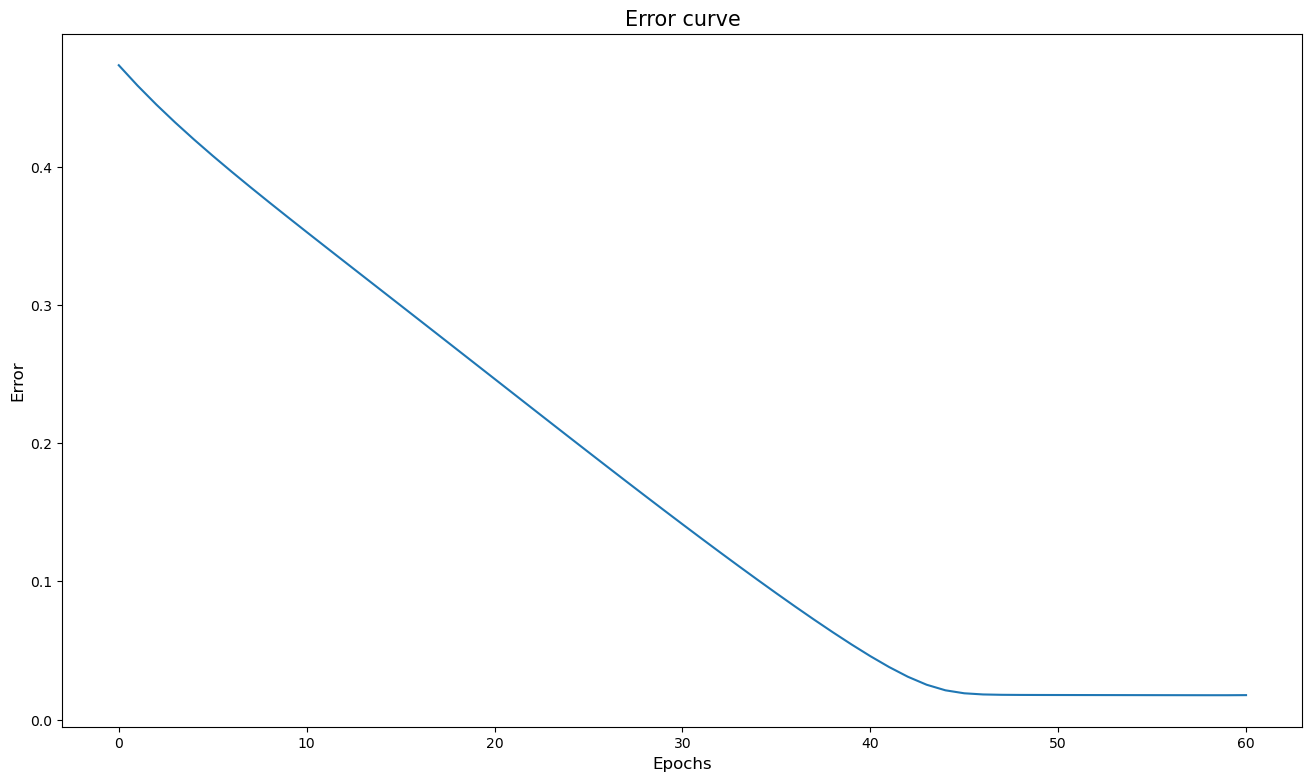

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16, 9))
plt.title('Error curve', fontsize=15)
plt.plot(points, [er.tolist() for er in errors])
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Error', fontsize=12)

plt.show()